<a href="https://colab.research.google.com/github/gentleman101/Deep_Learning/blob/main/OMR_Test_Scanner_(OpenCV).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optical Mark Recognition, or OMR for short, is the process of automatically analyzing human-marked documents and interpreting their results. 
ref: pyimagesearch.com

In [1]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

In [2]:
image='/content/drive/MyDrive/DATA/omr_test.png'
image = cv2.imread(image)

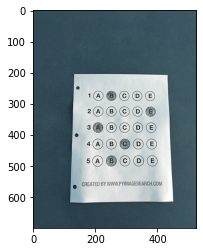

In [3]:
# Viewing the image
plt.imshow(image)

In [4]:
# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

## Image pre-processing

In [5]:
# load the image, convert it to grayscale, blur it
# slightly, then find edges
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

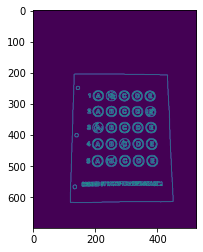

In [6]:
plt.imshow(edged)

## Finding countours and sorting them on the basis of their size

In [7]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

In [8]:
# ensure that at least one contour was found
if len(cnts) > 0:
	# sort the contours according to their size in
	# descending order
	cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
	# loop over the sorted contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)
		# if our approximated contour has four points,
		# then we can assume we have found the paper
		if len(approx) == 4:
			docCnt = approx
			break

## Transforming the image to 4 point view for a birds eye view

In [9]:
# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

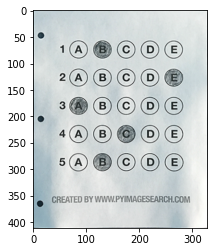

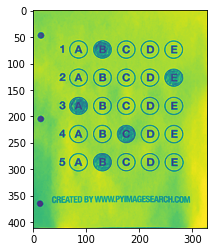

In [10]:
plt.imshow(paper)
plt.show()
plt.imshow(warped)
plt.show()

In [11]:
# apply Otsu's thresholding method to binarize the warped
# piece of paper
thresh = cv2.threshold(warped, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

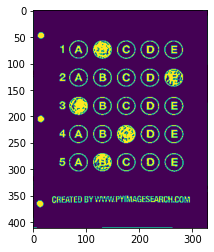

In [12]:
plt.imshow(thresh)

## Again finding contours to figure out the bubbles

In [13]:
# find contours in the thresholded image, then initialize
# the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour, then use the
	# bounding box to derive the aspect ratio
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)
	# in order to label the contour as a question, region
	# should be sufficiently wide, sufficiently tall, and
	# have an aspect ratio approximately equal to 1
	if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
		questionCnts.append(c)

In [16]:
# sort the question contours top-to-bottom, then initialize
# the total number of correct answers
questionCnts = contours.sort_contours(questionCnts,
	method="top-to-bottom")[0]
correct = 0
# each question has 5 possible answers, to loop over the
# question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
	# sort the contours for the current question from
	# left to right, then initialize the index of the
	# bubbled answer
	cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
	bubbled = None
  

## Creating a mask using thresh to calculate marked option

In [15]:
	# loop over the sorted contours
	for (j, c) in enumerate(cnts):
		# construct a mask that reveals only the current
		# "bubble" for the question
		mask = np.zeros(thresh.shape, dtype="uint8")
		cv2.drawContours(mask, [c], -1, 255, -1)
		# apply the mask to the thresholded image, then
		# count the number of non-zero pixels in the
		# bubble area
		mask = cv2.bitwise_and(thresh, thresh, mask=mask)
		total = cv2.countNonZero(mask)
		# if the current total has a larger number of total
		# non-zero pixels, then we are examining the currently
		# bubbled-in answer
		if bubbled is None or total > bubbled[0]:
			bubbled = (total, j)

In [17]:
	# initialize the contour color and the index of the
	# *correct* answer
	color = (0, 0, 255)
	k = ANSWER_KEY[q]
	# check to see if the bubbled answer is correct
	if k == bubbled[1]:
		color = (0, 255, 0)
		correct += 1
	# draw the outline of the correct answer on the test
	cv2.drawContours(paper, [cnts[k]], -1, color, 3)

array([[[134, 157, 170],
        [228, 249, 250],
        [217, 239, 243],
        ...,
        [144, 157, 166],
        [152, 162, 169],
        [129, 139, 144]],

       [[121, 143, 153],
        [222, 240, 243],
        [216, 235, 238],
        ...,
        [241, 243, 244],
        [245, 246, 247],
        [237, 240, 239]],

       [[103, 125, 133],
        [206, 225, 231],
        [204, 221, 226],
        ...,
        [247, 249, 248],
        [253, 254, 254],
        [230, 235, 234]],

       ...,

       [[140, 164, 176],
        [174, 201, 213],
        [156, 182, 194],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [198, 196, 196]],

       [[157, 181, 193],
        [191, 219, 231],
        [173, 201, 212],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [230, 226, 229]],

       [[ 90, 110, 123],
        [120, 140, 156],
        [111, 131, 145],
        ...,
        [206, 200, 202],
        [202, 198, 202],
        [179, 176, 181]]

[INFO] score: 20.00%


-1

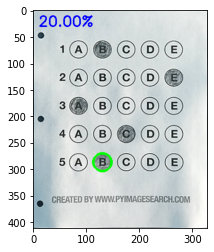

In [18]:
# grab the test taker
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),
	cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
plt.imshow(image)
plt.imshow(paper)
cv2.waitKey(0)

In [ ]:
0